In [ ]:
# Import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import csv
from datetime import datetime, timedelta

from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection #for plotting purposes

import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_name = 'CleanedData_Weekly.xlsx'
sheet_name = 'Firms Info'
firms_info = pd.read_excel(file_name, sheet_name, index_col=0)

In [ ]:
firms_info.head(5)

,Name,Sector
Ticker,,
FRC,First Republic,Bank
PNC,PNC Financial,Bank
USB,US Bancorp,Bank
JPM,JPMorgan Chase,Bank
BAC,Bank of America,Bank


In [ ]:
# Get and print the Sector Information
Sectors = firms_info.Sector.unique()
print(Sectors)

['Bank' 'Health' 'Energy' 'Tech' 'Market Index']


In [ ]:
# Load dataset for T-Bill
df_rf = pd.read_excel('CleanedData_Weekly.xlsx', 'T-Bill', index_col=0)
df_rf.index=pd.to_datetime(df_rf.index)

A Treasury Bill (T-Bill) is a short-term U.S. government debt obligation backed by the Treasury Department with a maturity of one year or less. Treasury bills are usually sold in denominations of $1,000.

Treasury bonds are considered risk-free assets, meaning there is no risk that the investor will lose their principal. In other words, investors that hold the bond until maturity are guaranteed their principal or initial investment.

In [ ]:
# Load Stock Return dataset 
file_name = 'CleanedData_Weekly.xlsx'
sheet_name = 'Stock Returns'
df = pd.read_excel(file_name, sheet_name, index_col=0)
df.index=pd.to_datetime(df.index)    
data = df.copy()

In [ ]:
data.head(5)

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,HSBC,JNJ,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,,,
2000-01-09,NaN,-0.032304,-0.049869,-0.058139,-0.029888,-0.030302,-0.042493,-0.032457,-0.123426,-0.113398,-0.076182,0.034852,0.067437,0.115349,0.054307,NaN,0.042568,0.003161,-0.032218,NaN,-0.045503,NaN,-0.018908
2000-01-16,NaN,0.097264,0.019338,0.015465,0.034659,0.074074,-0.017752,0.065494,0.037093,0.088261,-0.031279,-0.029146,0.072202,-0.010843,-0.013980,NaN,-0.036678,-0.070379,0.009422,NaN,0.007291,NaN,0.016428
2000-01-23,NaN,-0.061498,-0.094850,-0.012690,-0.093051,-0.026939,-0.035181,-0.121438,0.002128,-0.035047,-0.074364,-0.040694,-0.055555,-0.022765,0.014925,NaN,0.017960,0.016948,0.108278,NaN,-0.075724,NaN,-0.016237
2000-01-30,NaN,0.045583,0.005989,0.051414,0.001367,-0.005537,0.068037,0.058020,0.015318,-0.044340,0.014800,-0.059806,0.003565,0.054358,-0.072060,NaN,-0.067749,-0.041110,-0.087029,NaN,-0.053012,NaN,-0.056336
2000-02-06,NaN,-0.028609,0.014881,0.066015,-0.008197,-0.021727,-0.054815,0.000774,-0.026581,0.037512,-0.041666,-0.028107,0.015986,-0.017185,0.025358,NaN,-0.048448,-0.086906,0.062731,NaN,0.084604,NaN,0.047208


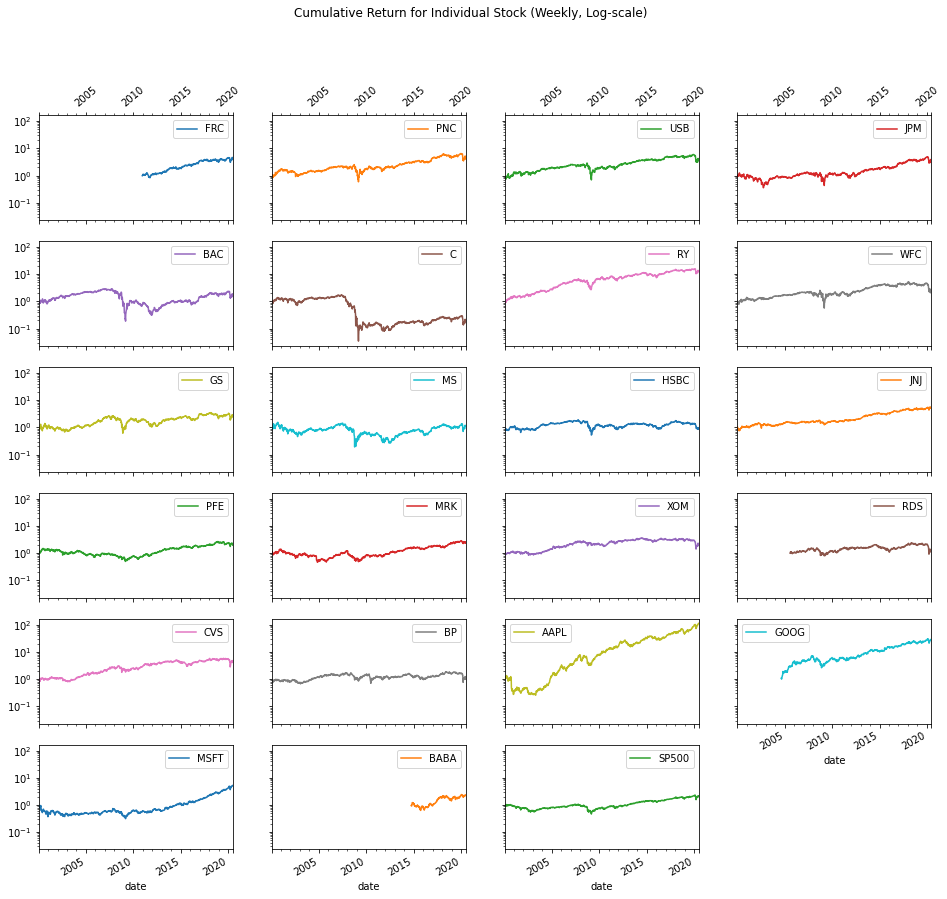

In [ ]:
# Plot cumulative return for each firm
lo_col = 4
lo_row = int(np.ceil(len(df.columns)/4))
f_hei = lo_row * 2.5
f_wid = lo_col * 4
ax = (data+1).cumprod().plot(subplots=True, layout=(lo_row, lo_col), figsize=(f_wid, f_hei),
                             logy=True, sharex=True, sharey=True,
                             title='Cumulative Return for Individual Stock (Weekly, Log-scale)');
for i in range(lo_col):
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
plt.show()

In [ ]:
#import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib.pylab as pl #for plotting purposes

import csv
from datetime import datetime, timedelta

from matplotlib.collections import LineCollection #for plotting purposes
from sklearn import cluster, covariance, manifold #for graphical analysis

In [ ]:
# ############################################################################################################################
# FUNCTIONS USED FOR GRAPHICAL ANALYSIS
# ############################################################################################################################

# Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

# #############################################################################
# Function for performing graphical network analysis
# Print clusters information, graphical network information, summary statistics, and plot of individual firm performance
# Return correlation and precision matrix, as well as plotting configuration information
# NOTE: it will drop the firms that have missing data during the specified time period

def graphicalAnalysis(dataset, start_date = '2000-01-01', end_date = '2020-05-31', 
                      Sectors_chosen = [],
                      drop_firm = []):
    
    # Check if the inputed date are legit
    if(datetime.strptime(start_date, "%Y-%m-%d") > datetime.strptime(end_date, "%Y-%m-%d")):
        print('ERROR: Revision needed! The entered \"start_date\" should be before \"end_date\".')
        return 0,0
    if (dataset.index[0]- timedelta(days=dataset.index[0].weekday()) > datetime.strptime(start_date, "%Y-%m-%d")):
        print('WARNING: the entered \"start_date\" is outside of the range for the given dataset.')
        print('The \"start_date\" is adjusted to the earliest start_date, i.e. ',
              (dataset.index[0]-timedelta(days=dataset.index[0].weekday())).strftime("%Y-%m-%d"))
        print()
    if (dataset.index[-1] < datetime.strptime(end_date, "%Y-%m-%d")):
        print('WARNING: the entered \"end_date\" is outside of the range for the given dataset.')
        print('The \"end_date\" is adjusted to the lastest end_date, i.e. ',
              dataset.index[-1].strftime("%Y-%m-%d"))
        print()
    
    # Extract the data for the given time period
    temp = dataset[dataset.index >= start_date].copy()
    X = temp[temp.index <= end_date].copy()    
    
    # Check if we are using all sectors or dropping some sector
    if ((not Sectors_chosen) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_chosen])):
            f_in_sector_chosen = []
            for s in Sectors_chosen:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
            X = X[f_in_sector_chosen]
            print('Sectors choosen in the Graphical Analysis are:')
            print(Sectors_chosen)
            print()
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if we are using all firm or dropping some firms
    if((not drop_firm) == False):
        if(all([(f in X.columns) for f in drop_firm])):
            print('The following Firms are dropped:')
            print(drop_firm)
            print()
            X.drop(columns = drop_firm, inplace = True)
        else:
            print('ERROR: Revision needed! At Least 1 firm entered in the \"drop_firm\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before doing graphical analysis
    if(X.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(X.columns[X.isna().any()]): print(Xcol_dropped)
        X = X.dropna(axis='columns')
        print()
    
    # Get the Start and End date of the dataset
    date_obj = X.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  X.index[-1].strftime("%m/%d/%Y")
    
    # Get the firm names of the dataset
    names = np.array(list(X.columns))
    
    # Show the number of firms examined
    print('Number of firms examined:', X.shape[1])
    
    
    # #############################################################################
    # Learn a graphical structure from the correlations
    
    # Graphical Lasso is used here to estimate the precision matrix    
    edge_model = covariance.GraphicalLassoCV(max_iter=1000)

    # standardize the time series: 
    # using correlations rather than covariance is more efficient for structure recovery
    X_std = X / X.std(axis=0)
    edge_model.fit(X_std)
    
    # #############################################################################
    # Cluster using affinity propagation

    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    
    for i in range(n_labels + 1):
        print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane

    node_position_model = manifold.MDS(n_components=2, random_state=0)
    embedding = node_position_model.fit_transform(X_std.T).T

    # #############################################################################
    # Visualization I
    
    # Specify node colors by cluster labels 
    color_list = pl.cm.jet(np.linspace(0,1,n_labels+1))
    my_colors = [color_list[i] for i in labels]
    
    # Compute the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    
    # Compute the edge values based on the partial correlations
    values = np.abs(partial_correlations[non_zero])
    val_max = values.max()
    
    # Title of the plot
    title = 'Graphical Network Analysis of Selected Firms over the Period '+start+' to '+end+' (Weekly)'
    
    # Display the partial correlation graph
    graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title)   
# END of function graphicalAnalysis

In [ ]:
###########################################   CAN BE CHANGED  #############################################

## Start and End date we are considering:
start_date = '2020-01-01'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank','Health','Energy','Tech']

## The list of firms we want to drop:
drop_firm = []

###########################################   CAN BE CHANGED  #############################################

In [ ]:
# #############################################################################
# Function Used for plotting the graphical network graph
def graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title):
        
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    n_labels = labels.max()
    
    #For correlation network graph
    fig = plt.figure(1, facecolor='w', figsize=(12, 5))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=500 * d ** 2, c= my_colors)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r, 
                        norm=plt.Normalize(0, .7 * val_max))
    lc.set_array(values)
    temp = (15 * values)
    temp2 = np.repeat(5, len(temp))
    w = np.minimum(temp, temp2)
    lc.set_linewidths(w)
    ax.add_collection(lc)
    axcb = fig.colorbar(lc)
    axcb.set_label('Strength')

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    plt.title(title)
    plt.show()
# END of function graphicalAnalysis_plot
# #############################################################################

Results over the time period  2020-01-01  to  2020-06-28 :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Number of firms examined: 22
Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL, GOOG, MSFT
Cluster 5: BABA


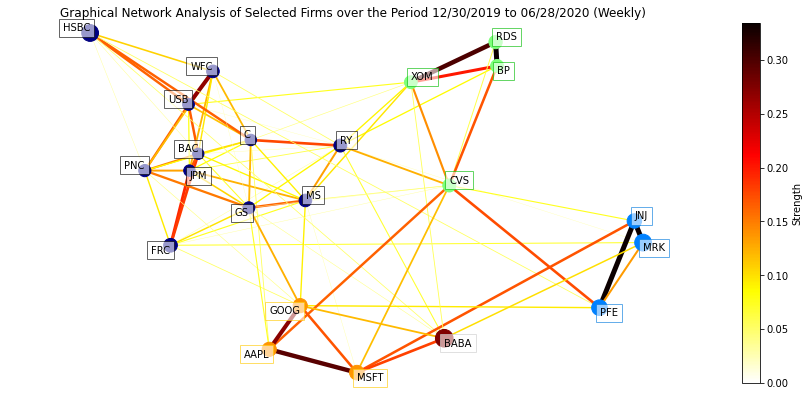

In [ ]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()

# Output the Clustering information, graphical network plot, 
# as well as summary statistics (optional) and the individual firm performance (optional)
# Store the correlation matrix and precision matrix in "est" (stands for estimates)
# Store the plotting configuration information in "con_fig" which will be needed if we want to use the ZOOM functions
## Note: you can view the correlation matrix by looking at est[0] and view the precision matrix by looking at est[1] 
graphicalAnalysis(data, start_date, end_date, Sectors_chosen, drop_firm)